In [1]:
from langchain_groq import ChatGroq
import os
from dotenv import load_dotenv

load_dotenv()


True

In [2]:
llm = ChatGroq(
    model_name="gemma2-9b-it",
    api_key=os.getenv("GROQ_API_KEY"),
)

In [3]:
llm.invoke(
    "What is the capital of France?",
).content

'The capital of France is **Paris**. \n'

In [4]:
import operator
from typing import List, Dict, Any, TypedDict, Annotated, Optional, Union, Literal
from pydantic import BaseModel, Field
from langchain_core.prompts import PromptTemplate, ChatPromptTemplate
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage, SystemMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough
from langgraph.graph import StateGraph, MessagesState, START, END
from langgraph.graph.message import add_messages
from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode

In [5]:
def call_model(state: MessagesState):
    question = state['messages']
    response = llm.invoke(question)
    return {"messages": [response]}

In [6]:
call_model(
    {
        "messages": [
            "What is the capital of France?"
        ]
    }
)

{'messages': [AIMessage(content='The capital of France is **Paris**. 🇫🇷  \n', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 15, 'prompt_tokens': 16, 'total_tokens': 31, 'completion_time': 0.027272727, 'prompt_time': 0.001865435, 'queue_time': 0.243490095, 'total_time': 0.029138162}, 'model_name': 'gemma2-9b-it', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'stop', 'logprobs': None}, id='run--265a0865-c2d8-4b1a-b184-c4f7e3059c16-0', usage_metadata={'input_tokens': 16, 'output_tokens': 15, 'total_tokens': 31})]}

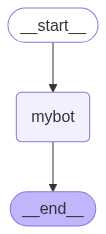

In [7]:
workflow = StateGraph(MessagesState)

workflow.add_node("mybot", call_model)

workflow.add_edge(START, "mybot")
workflow.add_edge("mybot", END)

app = workflow.compile()

from IPython.display import display, Image
display(Image(app.get_graph().draw_mermaid_png()))

In [8]:
app.invoke(
    {
        "messages": [
            "What is the capital of France?"
        ]
    }
)

{'messages': [HumanMessage(content='What is the capital of France?', additional_kwargs={}, response_metadata={}, id='a18532f3-f683-4478-bb15-d9093d7bb871'),
  AIMessage(content='The capital of France is **Paris**. 😊 \n', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 13, 'prompt_tokens': 16, 'total_tokens': 29, 'completion_time': 0.023636364, 'prompt_time': 0.001868766, 'queue_time': 0.27430628399999996, 'total_time': 0.02550513}, 'model_name': 'gemma2-9b-it', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'stop', 'logprobs': None}, id='run--e214968d-71dc-46d3-8e3d-a2a62e887068-0', usage_metadata={'input_tokens': 16, 'output_tokens': 13, 'total_tokens': 29})]}

### Tools

In [9]:
@tool
def search(query: str) -> str:
    """This is a custom tool for searching a weather"""
    if "delhi" in query.lower():
        return "the temperature in Delhi is 30 degrees Celsius"
    return "The temperature is 25 degrees Celsius in the city you asked about."

In [10]:
search.invoke("What is the weather in Delhi?")

'the temperature in Delhi is 30 degrees Celsius'

In [11]:
search.invoke("What is the weather in Mumbai?")

'The temperature is 25 degrees Celsius in the city you asked about.'

#### Binding tools

In [12]:
tools=[search]

In [13]:
tool_node = ToolNode(tools)

In [14]:
tool_node

tools(tags=None, recurse=True, explode_args=False, func_accepts_config=True, func_accepts={'store': ('__pregel_store', None)}, tools_by_name={'search': StructuredTool(name='search', description='This is a custom tool for searching a weather', args_schema=<class 'langchain_core.utils.pydantic.search'>, func=<function search at 0x10fe74700>)}, tool_to_state_args={'search': {}}, tool_to_store_arg={'search': None}, handle_tool_errors=True, messages_key='messages')

In [15]:
search

StructuredTool(name='search', description='This is a custom tool for searching a weather', args_schema=<class 'langchain_core.utils.pydantic.search'>, func=<function search at 0x10fe74700>)

In [16]:
llm_with_tools = llm.bind_tools(tools)


In [17]:
response = llm_with_tools.invoke(
    "What is the weather in Delhi?"
)

In [18]:
response.tool_calls

[{'name': 'search',
  'args': {'query': 'weather in Delhi'},
  'id': '1h1dcc7s7',
  'type': 'tool_call'}]

In [19]:
def call_model_with_tools(state: MessagesState):
    question = state['messages']
    response = llm_with_tools.invoke(question)
    return {"messages": [response]}

In [20]:
call_model_with_tools(
    {
        "messages": [
            "What is the weather in Delhi?"
        ]
    }
)

{'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'jk70ftdz2', 'function': {'arguments': '{"query":"weather in Delhi"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 80, 'prompt_tokens': 946, 'total_tokens': 1026, 'completion_time': 0.145454545, 'prompt_time': 0.053453358, 'queue_time': 0.24530833200000002, 'total_time': 0.198907903}, 'model_name': 'gemma2-9b-it', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--d3ac30f5-4cd8-492d-ae4e-a9fe01a641c3-0', tool_calls=[{'name': 'search', 'args': {'query': 'weather in Delhi'}, 'id': 'jk70ftdz2', 'type': 'tool_call'}], usage_metadata={'input_tokens': 946, 'output_tokens': 80, 'total_tokens': 1026})]}

In [21]:
def router_function(state: MessagesState):
    lst_msg = state['messages'][-1]
    if lst_msg.tool_calls:
        return "tools"
    return END

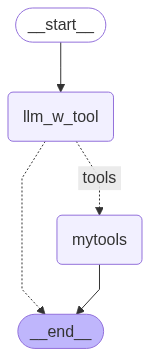

In [22]:
workflow_with_tools = StateGraph(MessagesState)

workflow_with_tools.add_node("llm_w_tool", call_model_with_tools)
workflow_with_tools.add_node("mytools",  tool_node)

workflow_with_tools.add_edge(START, "llm_w_tool")
workflow_with_tools.add_conditional_edges(
    "llm_w_tool",
    router_function,
    {
        "tools": "mytools",
        END: END
    }
)

app_with_tools = workflow_with_tools.compile()

display(Image(app_with_tools.get_graph().draw_mermaid_png()))

In [23]:
app_with_tools.invoke(
    {
        "messages": [
            "What is the weather in Delhi?"
        ]
    }
)

{'messages': [HumanMessage(content='What is the weather in Delhi?', additional_kwargs={}, response_metadata={}, id='65c266ae-197c-40ce-9eac-8c6b8b28532f'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': '6k6da3azb', 'function': {'arguments': '{"query":"weather in Delhi"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 82, 'prompt_tokens': 946, 'total_tokens': 1028, 'completion_time': 0.149090909, 'prompt_time': 0.032537069, 'queue_time': 0.24396978100000002, 'total_time': 0.181627978}, 'model_name': 'gemma2-9b-it', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--9d1a0469-d82a-4d3a-ad73-8f936ef84eec-0', tool_calls=[{'name': 'search', 'args': {'query': 'weather in Delhi'}, 'id': '6k6da3azb', 'type': 'tool_call'}], usage_metadata={'input_tokens': 946, 'output_tokens': 82, 'total_tokens': 1028}),
  ToolMessage(content='the temperature in Delhi is 30 degrees Celsius', name

In [24]:
app_with_tools.invoke(
    {
        "messages": [
            "What is the weather in Mumbai?"
        ]
    }
)

{'messages': [HumanMessage(content='What is the weather in Mumbai?', additional_kwargs={}, response_metadata={}, id='980e93c4-ad03-49d0-95f5-5dad8f178e70'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': '90vw1tnzz', 'function': {'arguments': '{"query":"weather in Mumbai"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 80, 'prompt_tokens': 946, 'total_tokens': 1026, 'completion_time': 0.145454545, 'prompt_time': 0.032510749, 'queue_time': 0.25096718, 'total_time': 0.177965294}, 'model_name': 'gemma2-9b-it', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--8525ff15-1103-4b21-a36d-50d8519d9acf-0', tool_calls=[{'name': 'search', 'args': {'query': 'weather in Mumbai'}, 'id': '90vw1tnzz', 'type': 'tool_call'}], usage_metadata={'input_tokens': 946, 'output_tokens': 80, 'total_tokens': 1026}),
  ToolMessage(content='The temperature is 25 degrees Celsius in the city you asked

In [25]:
app_with_tools.invoke(
    {
        "messages": [
            "What is capital of France?"
        ]
    }
)

{'messages': [HumanMessage(content='What is capital of France?', additional_kwargs={}, response_metadata={}, id='2dd8d9ca-4d3a-4c52-b818-e2acf9cbbc1a'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': '8vw65ypeh', 'function': {'arguments': '{"query":"capital of France"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 80, 'prompt_tokens': 945, 'total_tokens': 1025, 'completion_time': 0.145454545, 'prompt_time': 0.03258311, 'queue_time': 0.24518504900000002, 'total_time': 0.178037655}, 'model_name': 'gemma2-9b-it', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--300430f6-68ef-485c-8567-2e62c716c188-0', tool_calls=[{'name': 'search', 'args': {'query': 'capital of France'}, 'id': '8vw65ypeh', 'type': 'tool_call'}], usage_metadata={'input_tokens': 945, 'output_tokens': 80, 'total_tokens': 1025}),
  ToolMessage(content='The temperature is 25 degrees Celsius in the city you a

### cyclic graph

In [26]:
workflow_with_tools.add_edge("mytools", "llm_w_tool")

Adding an edge to a graph that has already been compiled. This will not be reflected in the compiled graph.


In [27]:
app_with_tools_cyclic = workflow_with_tools.compile()

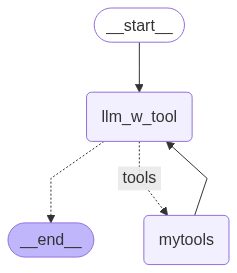

In [28]:
from IPython.display import display, Image
display(Image(app_with_tools_cyclic.get_graph().draw_mermaid_png()))

In [31]:
for output in app_with_tools_cyclic.stream(
    {
        "messages": [
            "What is the weather in Delhi? Can you tell me good hotels in Delhi?"
        ]
    }
):
    for key, value in output.items():
        print(f"{key}: {value}")
        print("-" * 20)
        
print("End of output")

llm_w_tool: {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'ec35023pg', 'function': {'arguments': '{"query":"weather in Delhi"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 82, 'prompt_tokens': 955, 'total_tokens': 1037, 'completion_time': 0.149090909, 'prompt_time': 0.040840051, 'queue_time': 0.245458069, 'total_time': 0.18993096}, 'model_name': 'gemma2-9b-it', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--212a6c01-ecda-44ac-bf9c-9956b408efa1-0', tool_calls=[{'name': 'search', 'args': {'query': 'weather in Delhi'}, 'id': 'ec35023pg', 'type': 'tool_call'}], usage_metadata={'input_tokens': 955, 'output_tokens': 82, 'total_tokens': 1037})]}
--------------------
mytools: {'messages': [ToolMessage(content='the temperature in Delhi is 30 degrees Celsius', name='search', id='cc9693f6-f823-403a-822b-a0880f13cd83', tool_call_id='ec35023pg')]}
----------------

### Memory

In [32]:
from langgraph.checkpoint.memory import MemorySaver

In [33]:
memory = MemorySaver()

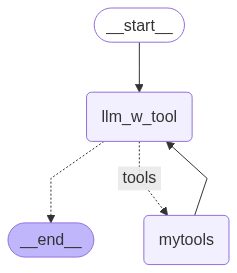

In [36]:
workflow_with_tools_memory = StateGraph(MessagesState)

workflow_with_tools_memory.add_node("llm_w_tool", call_model_with_tools)
workflow_with_tools_memory.add_node("mytools",  tool_node)
workflow_with_tools_memory.add_edge("mytools", "llm_w_tool")

workflow_with_tools_memory.add_edge(START, "llm_w_tool")
workflow_with_tools_memory.add_conditional_edges(
    "llm_w_tool",
    router_function,
    {
        "tools": "mytools",
        END: END
    }
)

app_with_tools_memory = workflow_with_tools_memory.compile(checkpointer=memory)

display(Image(app_with_tools_memory.get_graph().draw_mermaid_png()))

In [37]:
config = {
    "configurable": {
        "thread_id": "1"
    }
}

In [38]:
event = app_with_tools_memory.stream(
    {
        "messages": [
            "What is the weather in Delhi? Can you tell me good hotels in Delhi?"
        ]
    },
    config=config,
    stream_mode="values"
)

In [40]:
for output in event:
    output["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  search (msrcsjjab)
 Call ID: msrcsjjab
  Args:
    query: weather in Delhi
================================= Tool Message =================================
Name: search

the temperature in Delhi is 30 degrees Celsius
================================== Ai Message ==================================
Tool Calls:
  search (k26e368ca)
 Call ID: k26e368ca
  Args:
    query: good hotels in Delhi
================================= Tool Message =================================
Name: search

the temperature in Delhi is 30 degrees Celsius
================================== Ai Message ==================================

Some highly-rated hotels in Delhi include The Oberoi, The Leela Palace, and The Taj Palace.


In [41]:
memory.get(config)

{'v': 3,
 'ts': '2025-06-17T13:57:28.987145+00:00',
 'id': '1f04b830-1b43-654a-8005-83ebaccc4de9',
 'channel_versions': {'__start__': '00000000000000000000000000000002.0.9825415920165259',
  'messages': '00000000000000000000000000000007.0.9759722393025856',
  'branch:to:llm_w_tool': '00000000000000000000000000000007.0.96912135217143',
  'branch:to:mytools': '00000000000000000000000000000006.0.5165378306324228'},
 'versions_seen': {'__input__': {},
  '__start__': {'__start__': '00000000000000000000000000000001.0.955671112079471'},
  'llm_w_tool': {'branch:to:llm_w_tool': '00000000000000000000000000000006.0.5724009290829353'},
  'mytools': {'branch:to:mytools': '00000000000000000000000000000005.0.7731320341794432'}},
 'channel_values': {'messages': [HumanMessage(content='What is the weather in Delhi? Can you tell me good hotels in Delhi?', additional_kwargs={}, response_metadata={}, id='5e2a7114-2058-4cae-9adf-4e559acaeb4c'),
   AIMessage(content='', additional_kwargs={'tool_calls': [{'i

In [42]:
event2 = app_with_tools_memory.stream(
    {
        "messages": [
            "What is the weather in Mumbai? Can you tell me good hotels in Mumbai?"
        ]    },
    config=config,
    stream_mode="values"
)

In [43]:
for output in event2:
    output["messages"][-1].pretty_print()

================================ Human Message =================================

What is the weather in Mumbai? Can you tell me good hotels in Mumbai?
================================== Ai Message ==================================
Tool Calls:
  search (5qkgerce3)
 Call ID: 5qkgerce3
  Args:
    query: weather in Mumbai
================================= Tool Message =================================
Name: search

The temperature is 25 degrees Celsius in the city you asked about.
================================== Ai Message ==================================

Some highly-rated hotels in Mumbai include The Taj Mahal Palace, The Oberoi, and The St. Regis.


In [44]:
memory.get(config)

{'v': 3,
 'ts': '2025-06-17T14:04:15.004439+00:00',
 'id': '1f04b83f-3b58-6754-800a-c8498a58f8cc',
 'channel_versions': {'__start__': '00000000000000000000000000000009.0.28019577100753623',
  'messages': '00000000000000000000000000000012.0.9215719864416619',
  'branch:to:llm_w_tool': '00000000000000000000000000000012.0.7051654314274487',
  'branch:to:mytools': '00000000000000000000000000000011.0.22800255853666307'},
 'versions_seen': {'__input__': {},
  '__start__': {'__start__': '00000000000000000000000000000008.0.27150894523402747'},
  'llm_w_tool': {'branch:to:llm_w_tool': '00000000000000000000000000000011.0.8508879316950201'},
  'mytools': {'branch:to:mytools': '00000000000000000000000000000010.0.37675902632016045'}},
 'channel_values': {'messages': [HumanMessage(content='What is the weather in Delhi? Can you tell me good hotels in Delhi?', additional_kwargs={}, response_metadata={}, id='5e2a7114-2058-4cae-9adf-4e559acaeb4c'),
   AIMessage(content='', additional_kwargs={'tool_calls